In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [2]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/bald_eagle
oregon_wildlife/black_bear
oregon_wildlife/cougar
oregon_wildlife/deer
oregon_wildlife/nutria
oregon_wildlife/raccoon
oregon_wildlife/raven
oregon_wildlife/red_fox
oregon_wildlife/sea_lions
oregon_wildlife/virginia_opossum

total img num: 7168


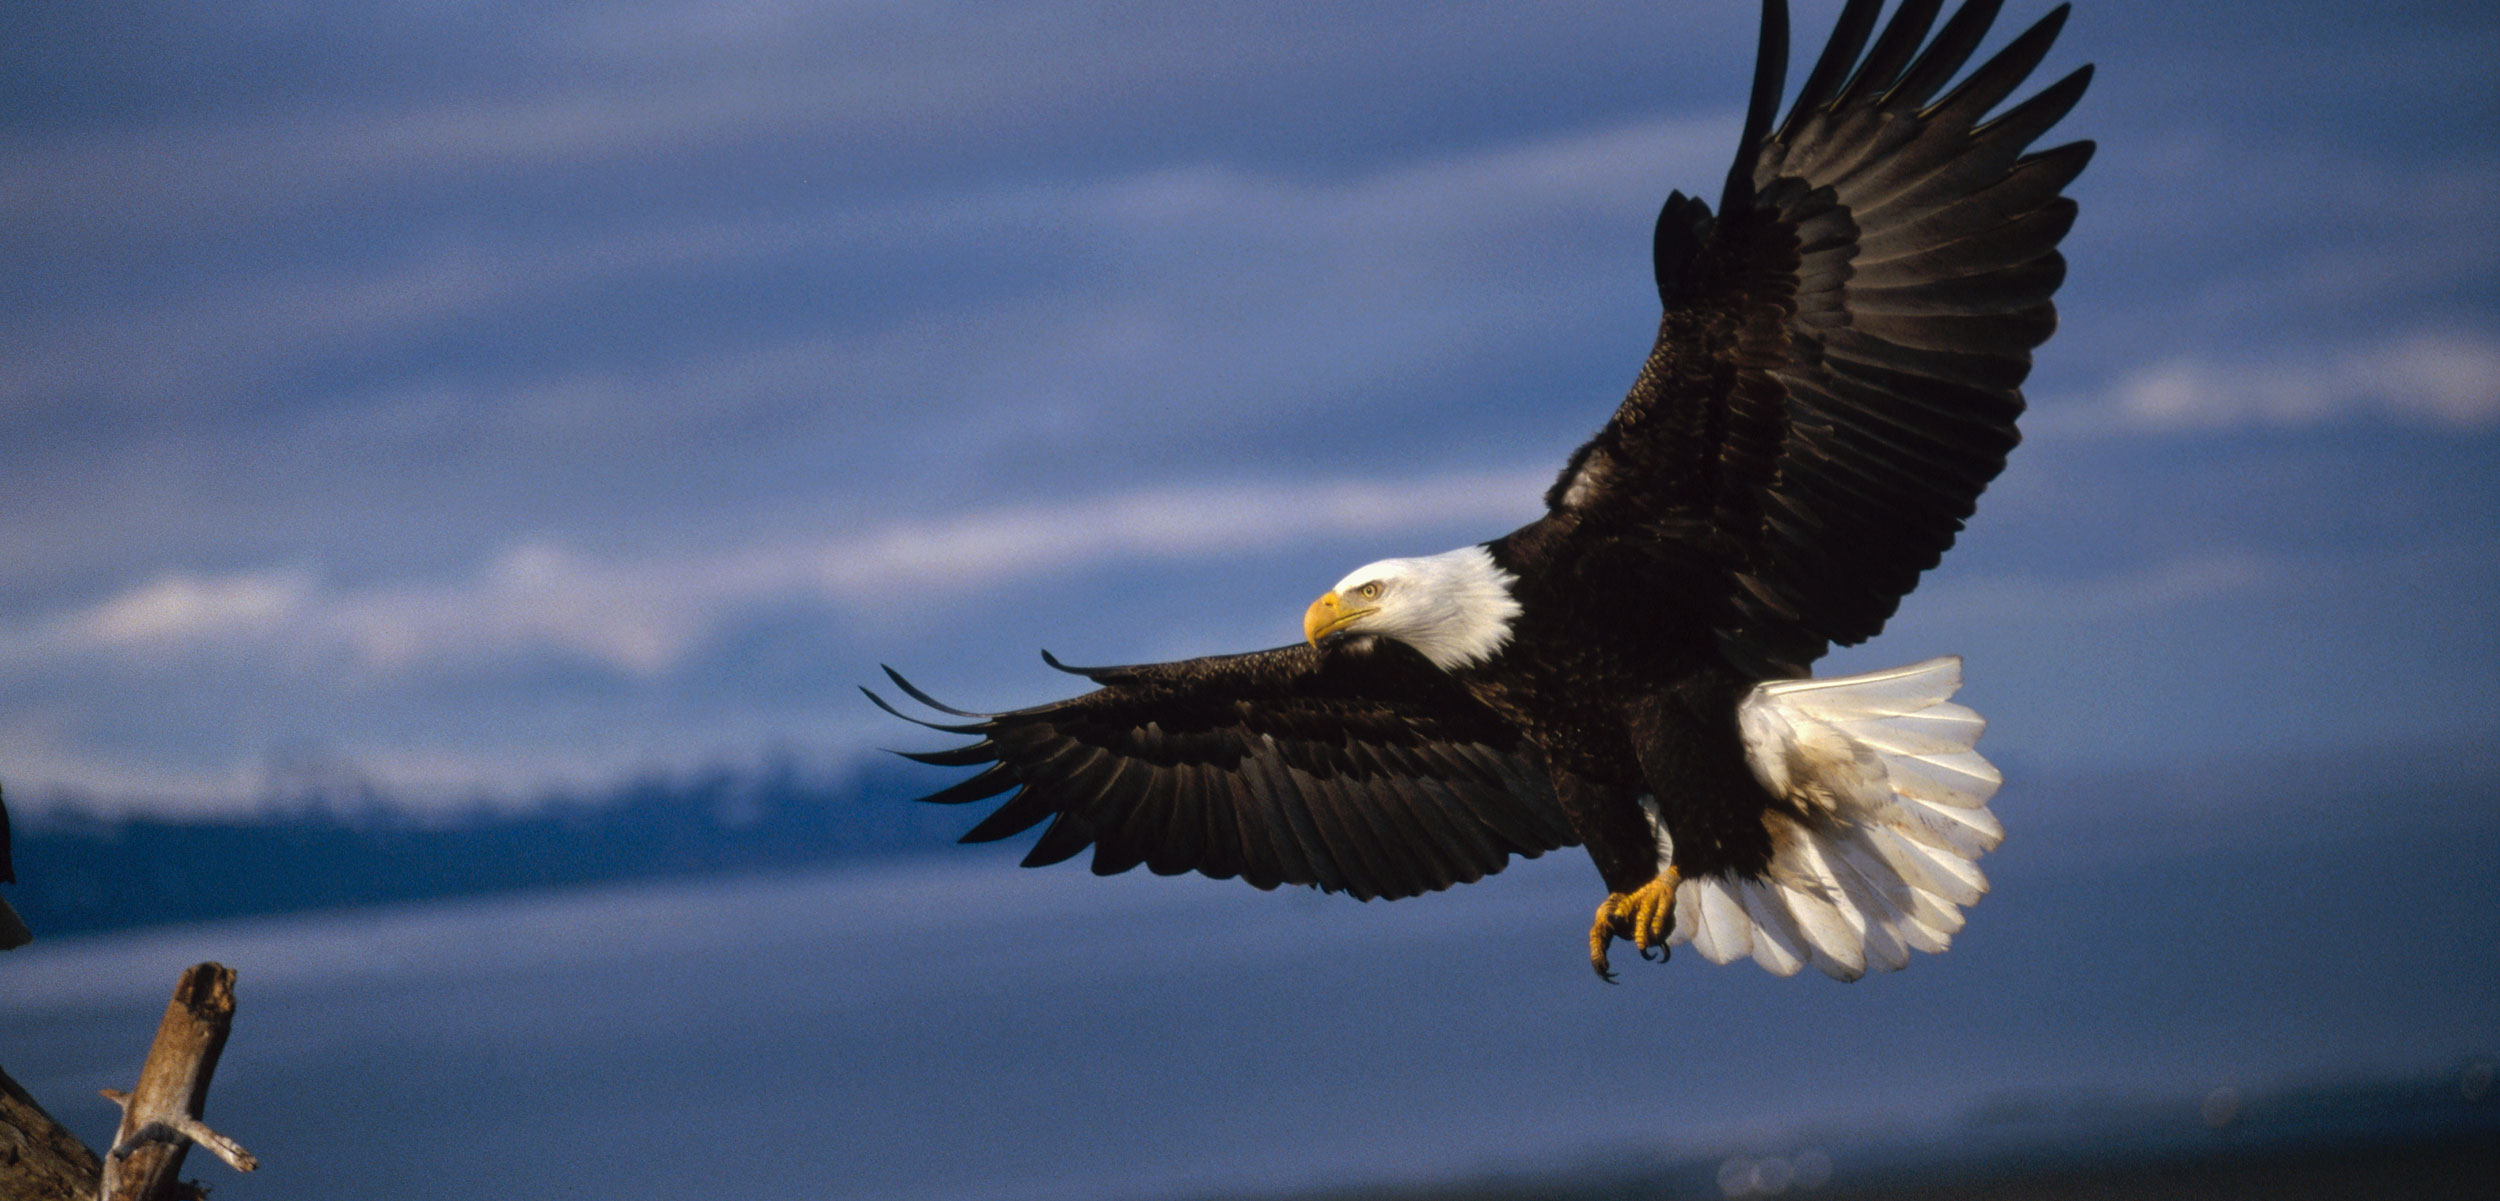

bald_eagle


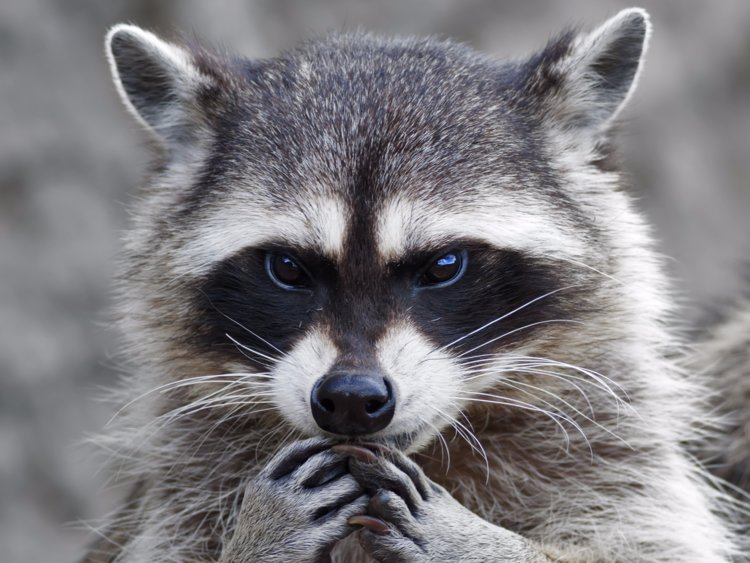

raccoon


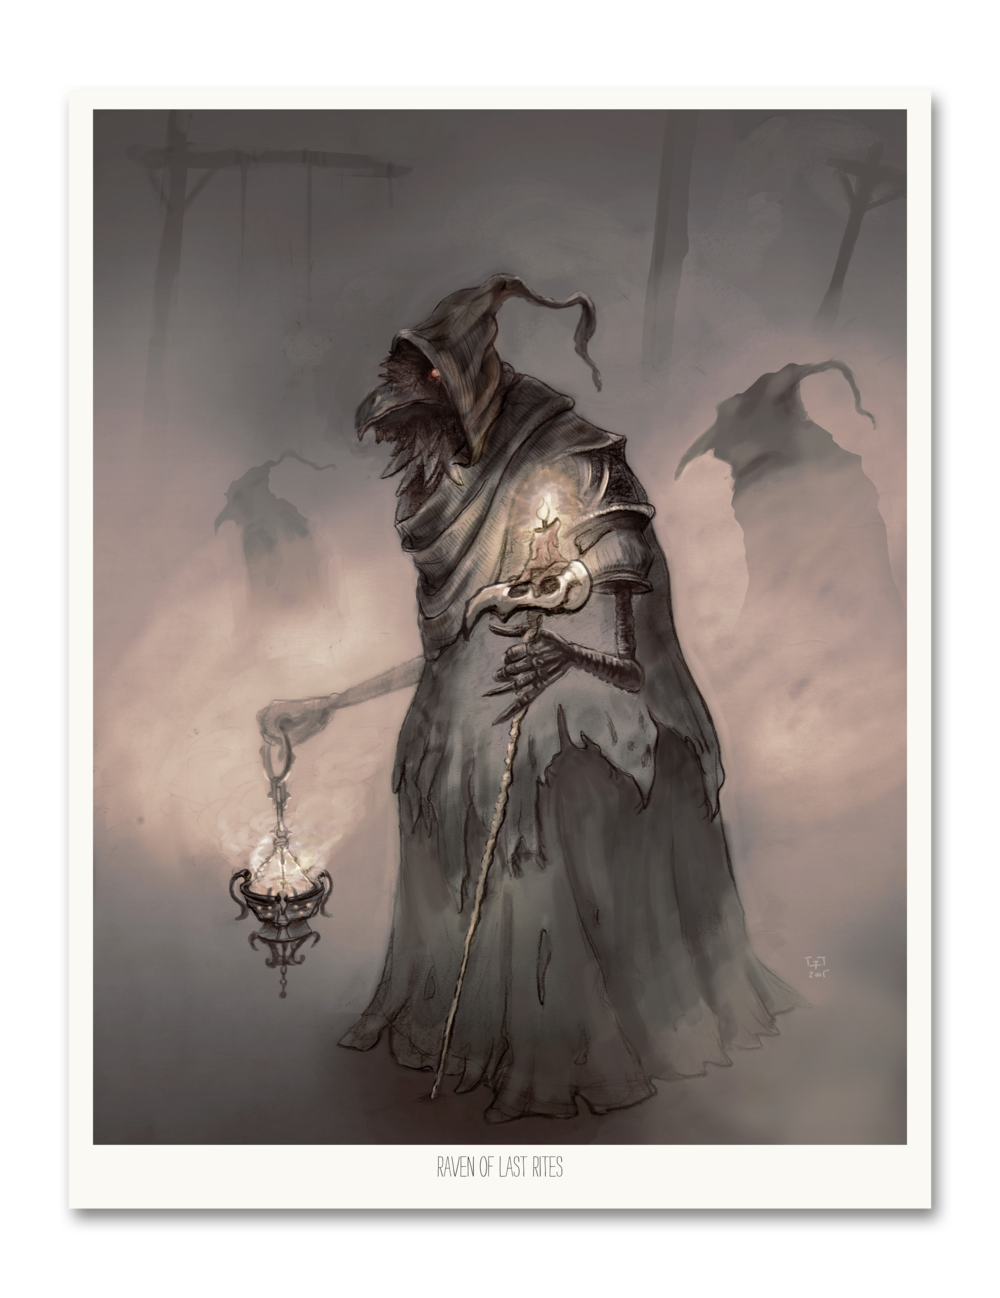

raven


In [3]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [4]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [5]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [6]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [7]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [8]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [9]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [10]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [11]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [12]:
# feel free to modify these two Settings.
BUFFER_SIZE = 1000
BATCH_SIZE = 32

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[7.407887e+05 9.280879e-03]
 [7.407887e+05 7.425293e-03]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


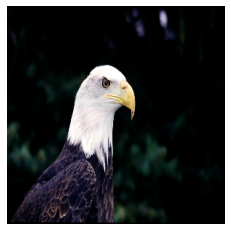

bald_eagle


In [13]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [14]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [15]:
wild_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [16]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [18]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [19]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            # time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            # time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            # time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            # time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [20]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  740794.381461664
training:


100%|██████████| 179/179 [01:19<00:00,  2.26it/s]

testing:



100%|██████████| 44/44 [00:19<00:00,  2.26it/s]

Epoch 1, Loss: 4.1567, Accuracy: 32.2277, test Loss: 1.0447, test Accuracy: 66.4773
training:



100%|██████████| 179/179 [01:16<00:00,  2.33it/s]

testing:



100%|██████████| 44/44 [00:19<00:00,  2.27it/s]

Epoch 2, Loss: 1.1973, Accuracy: 58.1529, test Loss: 0.7658, test Accuracy: 75.8523
training:



100%|██████████| 179/179 [01:15<00:00,  2.37it/s]

testing:



100%|██████████| 44/44 [00:19<00:00,  2.27it/s]

Epoch 3, Loss: 0.9829, Accuracy: 65.9916, test Loss: 0.6046, test Accuracy: 82.2443
Execution time: 290.040627563023


In [21]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

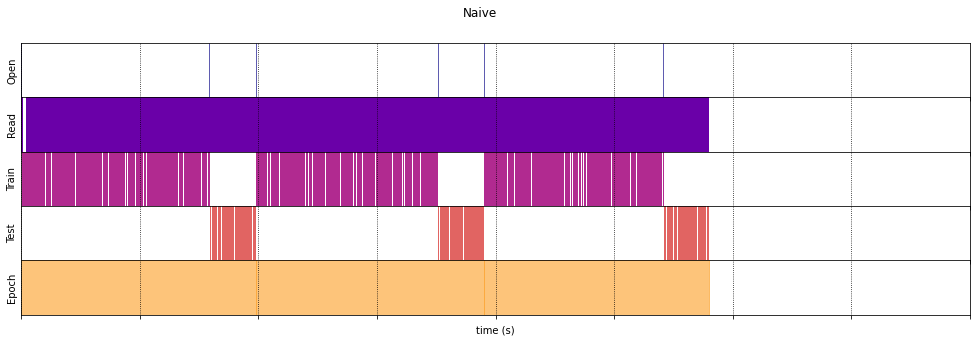

In [22]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=400)

## input transfromation

In [23]:
def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.int32)
        )
    return wrapper

@map_decorator
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label


@map_decorator
def map_fun_test(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    map_enter = time.perf_counter()

    distorted_image = tf.image.per_image_standardization(image)

    map_elapsed = time.perf_counter() - map_enter

    return  tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

In [24]:


dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).map(map_fun).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).map(map_fun_test).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)


In [25]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  741089.018764177
training:


100%|██████████| 179/179 [01:32<00:00,  1.94it/s]

testing:



100%|██████████| 44/44 [00:22<00:00,  1.97it/s]

Epoch 1, Loss: 5.8852, Accuracy: 53.2472, test Loss: 0.4685, test Accuracy: 86.1506
training:



100%|██████████| 179/179 [01:31<00:00,  1.95it/s]

testing:



100%|██████████| 44/44 [00:22<00:00,  1.97it/s]

Epoch 2, Loss: 0.7130, Accuracy: 76.3443, test Loss: 0.3215, test Accuracy: 91.9034
training:



100%|██████████| 179/179 [01:32<00:00,  1.94it/s]

testing:



100%|██████████| 44/44 [00:22<00:00,  1.97it/s]

Epoch 3, Loss: 0.4960, Accuracy: 84.5845, test Loss: 0.2591, test Accuracy: 92.4006
Execution time: 343.25290288205724


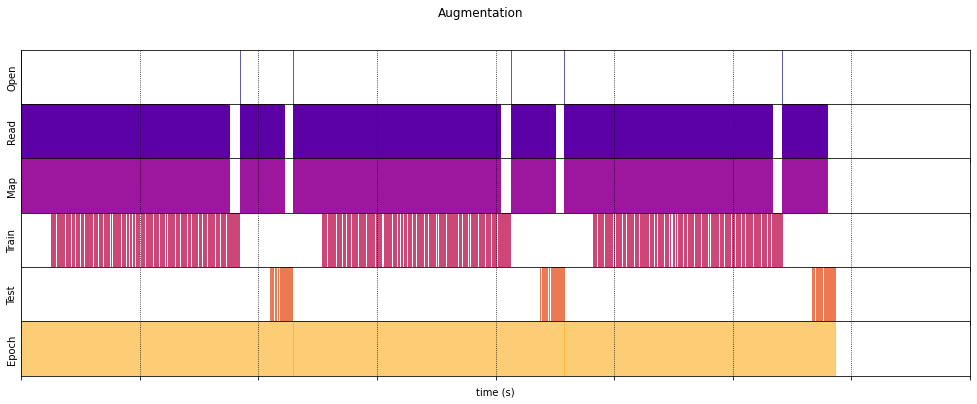

In [26]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=400)

## input transfromation with optimization terms

In [27]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated
@map_decorator
def map_fun_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    # image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    # image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    # label = tf.one_hot(label, 10)
    # distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    # image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    # image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    # label = tf.one_hot(label,10)
    # distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.per_image_standardization(image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_fun_test_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

In [28]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  741434.936885495
training:


100%|██████████| 179/179 [01:25<00:00,  2.10it/s]

testing:



100%|██████████| 44/44 [00:21<00:00,  2.08it/s]

Epoch 1, Loss: 5.4620, Accuracy: 52.5140, test Loss: 0.5718, test Accuracy: 85.2983
training:



100%|██████████| 179/179 [00:23<00:00,  7.52it/s]

testing:



100%|██████████| 44/44 [00:05<00:00,  8.55it/s]

Epoch 2, Loss: 0.7016, Accuracy: 78.4916, test Loss: 0.2995, test Accuracy: 90.5540
training:



100%|██████████| 179/179 [00:24<00:00,  7.40it/s]

testing:



100%|██████████| 44/44 [00:05<00:00,  8.42it/s]

Epoch 3, Loss: 0.4614, Accuracy: 85.9288, test Loss: 0.2610, test Accuracy: 92.1165
Execution time: 164.8840285340557


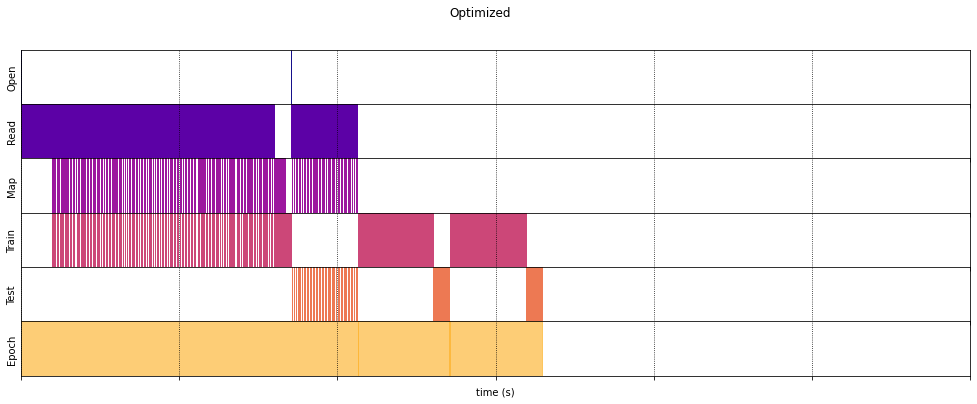

In [29]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=300)


## Results
1. Naive:  
  test Accuracy: 82.2443, Execution time: 290.040627563023
2. input transfromation:   
  test Accuracy: 92.4006, Execution time: 343.25290288205724
3. with optimized terms:   
  test Accuracy: 92.1165, Execution time: 164.8840285340557  

## Summary  
Compared to Naive's method, it took longer time with input transfromation(shuffle, batch, repeat, map) but got a better 
accuracy.Furthermore, if we add some optimized terms(interleave,prefetch, cache) the time is shorter but still have a good accuracy.  